# Introduction to time series analysis

This notebook provides an overview of time series analysis. Time series are a very common type of data. Applications of time series analysis include:

- **Demand forecasting:** electricity production, internet bandwidth, traffic management, inventory management
- **Medicine:** time dependent treatment effects, IoT monitoring devices
- **Engineering and science:** signal analysis, analysis of physical processes
- **Capital markets and economics:** seasonal unemployment, risk analysis, financial analysis

In this lesson you will learn the following:

- Basic properties of time series
- How to perform and understand decomposition of time series
- Modeling of time series residuals and the ARIMA model
- Forecasting time series values from models

What sets **time series data** apart from the kind of data we have been dealing with so far (sometimes referred to as **cross-sectional data**) is that in time series data, we are really only interested in predictions *beyond the range* of available data. This means that we look at the past not so much to model the past, but rather to predict the future, which we also call **forecasting**. We say that forecasting is a type of **extrapolation**, whereas in predicting in general is usually a type of **interpolation**. Of course we may also need to extrapolate with cross-sectional data, but with time series data extrapolation is the rule, not the exception. As we will see, in practice, many of the methods we learned for linear regression can still be employed here, but with some modification.

Another important new word we encounter in this notebook in the the word **process**: In the past notebooks, generating random samples from a distribution was called **Monte Carlo simulations**. In the context of time series data where each sample generated may depend on the previous ones, we use the word **process** instead, and we say the data was generated using a **stochastic process** where the word stochastic means that it's probability-based and hence noisy (the opposite of the word **deterministic**). So we say that we are generating a sequence of random numbers based on a stochastic process, i.e. a probability rule that links each instance to the previous ones.

## Working with time series in `pandas`

There are significant capabilities in `pandas` for working with time series data. The trick is to use the timestamp as row index for the data. Let's start with a simple univariate time series.

In [1]:
from math import sin, pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as nr

import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error

import statsmodels.graphics.tsaplots as splt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima_process
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 5]

Here are two helper functions we will be referring to several time during the notebook.

In [2]:
def plot_acf_pacf(x, lags = 40):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = splt.plot_acf(x, lags = lags, ax = axes[0])
    fig = splt.plot_pacf(x, lags = lags, ax = axes[1]);
    return None

def plot_ts_resid(x):
    x = x[x.notna()] # remove NAs
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    fig = sns.lineplot(x.index, x, ax = axes[0])
    fig = sns.distplot(x, ax = axes[1]);
    return None

Let's now start with some series of numbers.

In [3]:
ts = pd.Series([sin(x/30.0) for x in range(366)])
ts.head(5)

0    0.000000
1    0.033327
2    0.066617
3    0.099833
4    0.132939
dtype: float64

The object we created is a series of floating point values. However, this is not yet a time series. For that, we need to add an index.

In [4]:
ts.index = pd.date_range(start = '1-1-2016', end = '12-31-2016', freq = 'D')
ts.head(5)

2016-01-01    0.000000
2016-01-02    0.033327
2016-01-03    0.066617
2016-01-04    0.099833
2016-01-05    0.132939
Freq: D, dtype: float64

You can see that the index is now the date-time for each value. Let's plot the time series.

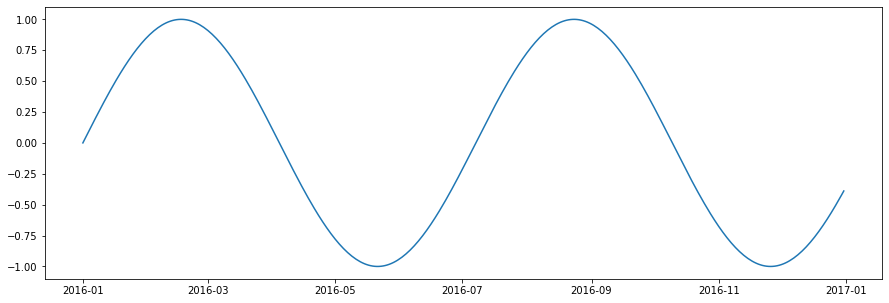

In [5]:
sns.lineplot(x = ts.index, y = ts);

You can see that the time axis is labeled automatically, and the tick marks on the x-axis are made sparse enough so as not to overcrowd the plot.

Since the index is a timestamp, we can slice the data using timestamp cut-offs:

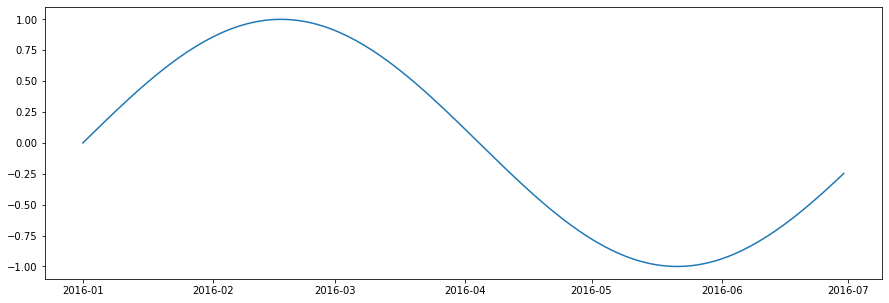

In [6]:
ts_slice = ts['1/1/2016':'6/30/2016']
sns.lineplot(x = ts_slice.index, y = ts_slice);

Notice that the plot covers the subset of dates specified. 

## White noise

In this section we will explore some basic properties time series. Understanding these properties will help in understanding the models we explore in subsequent sections.

A series $\{X_t\} = \{X_1, X_2, \cdots\}$ of **independent identically distributed (IID)** random variables $X_t \sim N(0, \sigma)$ drawn from a normal distribution is said to be a **white noise** series. Since the series is IID there is no correlation from one value to the next. Usually $t$ is descrete and evenly-spaced, such as $t = 1, 2, \dots$, but $t$ can also be discrete but unevenly spaced, or even continuous. In practice, when the time variable is continuous, we end up sampling it at discrete and usually evenly-spaced time points so it becomes discrete.

If we successfully model the time series so that any *trend* in the data is explained away, then what remains should look like white noise. To **detrend** time series data, we need to capture all time-dependent relationships that exist in the data.

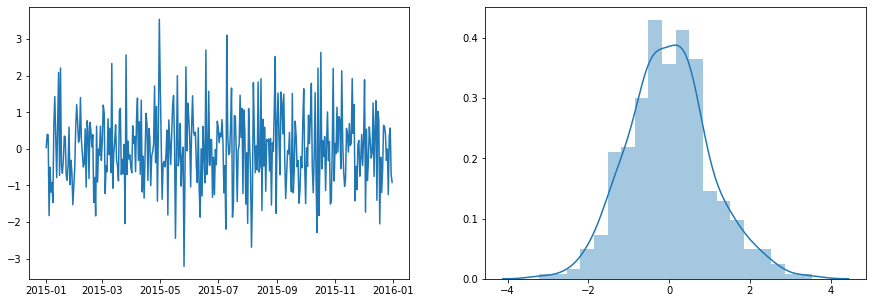

In [9]:
index = pd.date_range(start = '1-1-2015', end = '12-31-2015', freq = 'D')
wn = pd.Series(nr.normal(size = len(index)), index = index)
plot_ts_resid(wn);

Notice that the values of the time series wander randomly around zero, with no particular trend. As expected, the values of the white noise series are normally distributed.

The values of the white noise series are IID, so we do not expect the values to show any dependency over time. In time series analysis we measure dependency using **auto-correlation**. Auto-correlation is the correlation of a series with itself **lagged** (offset in time) by some number of time steps. Auto-correlation at lag $k$, denoted by $\rho_k$ is the correlation between $X_t$ and $X_{t-k}$ for all times $t$. Notice that for any series, $\rho_0 = 1$.

We can also define a second order **partial auto-correlation**. The partial autocorrelation at lag $k$ is the correlation that remains after we remove the effect of any correlations due to the terms $X_{t-i}$ for $i<k$. We can think of this as being the **direct effect** at lag $k$ after removing all indirect effects at lags $i = 1, \dots, k-1$. There are more computationally efficient ways to calculate partial auto-correlation, but the most intuitive way to do so is the following: If $X_t = \phi_1X_{t-1} + \phi_2X_{t-2}$ then $\phi_2$ is the partial auto-correlation at lag 2.

### Exercise

Let's read in the white noise series from above into a `DataFrame` and explore some time series functionality in `pandas`:

In [10]:
data_ts = pd.DataFrame({'x': wn})
data_ts.head()

,x
2015-01-01,0.033009
2015-01-02,0.398397
2015-01-03,0.384277
2015-01-04,-1.826461
2015-01-05,-0.498286


- Create two new features `x_roll` and `x_ewma` which are moving averages and exponentially weighted moving averages of `x`. Then plot a line plot of all three. HINT: Use the `rolling` and `ewm` methods. Explore their arguments to see how we can make the data more smooth or less smooth.

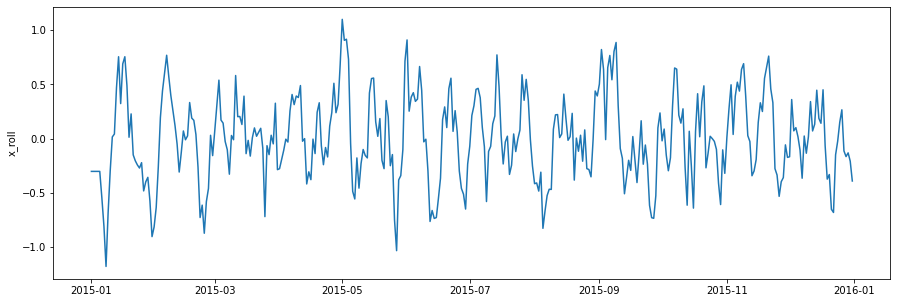

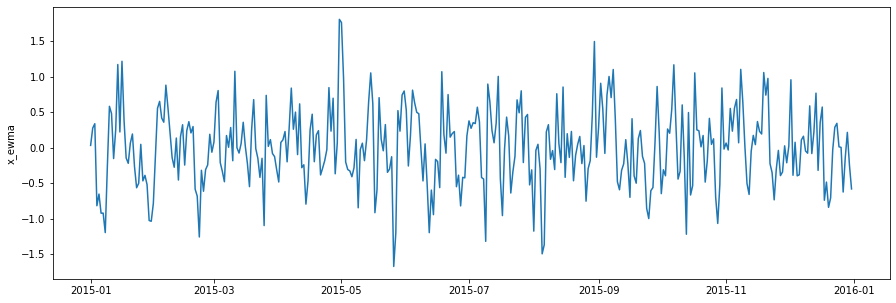

In [30]:
# bfill backfills the missing data.
# there's also ffil and fill (forward fill and fill with a specific value)
data_ts['x_roll'] = data_ts['x'].rolling(5).mean().bfill()
data_ts['x_ewma'] = data_ts['x'].ewm(1).mean()

sns.lineplot(x = data_ts.index, y = 'x_roll', data = data_ts);
plt.show();

sns.lineplot(x = data_ts.index, y = 'x_ewma', data = data_ts);
plt.show();

- Create a new column called `x_lag_1` which is the lag of `x` (each row of `x_lag_1` is stores the value of `x` in the previous row. HINT: Use the `shift` method.

In [26]:
data_ts['x_lag_1'] = data_ts['x'].shift(periods=1)
data_ts.head()

,x,x_roll,x_ewma,x_lag_1
2015-01-01,0.033009,NaN,0.033009,NaN
2015-01-02,0.398397,0.215703,0.252242,0.033009
2015-01-03,0.384277,0.391337,0.314785,0.398397
2015-01-04,-1.826461,-0.721092,-0.574656,0.384277
2015-01-05,-0.498286,-1.162373,-0.545338,-1.826461


- Find the auto-correlation and partial auto-correlation at lag $k = 2$ for the white-noise series in the above data.

In [31]:
data_ts['x_lag_2'] = data_ts['x'].shift(2)
data_ts.corr()

,x,x_roll,x_ewma,x_lag_1,x_lag_2
x,1.000000,0.404000,0.869051,-0.094612,-0.086403
x_roll,0.404000,1.000000,0.697169,0.384353,0.331613
x_ewma,0.869051,0.697169,1.000000,0.345084,0.090814
x_lag_1,-0.094612,0.384353,0.345084,1.000000,-0.096477
x_lag_2,-0.086403,0.331613,0.090814,-0.096477,1.000000


- Find the partial auto-correlation at lag $k = 2$ for the white-noise series. 

  HINT: To do this, you need to train a linear regression model without the intercept term. You can drop the intercept term from a model by adding `-1` to the formula argument in `sm.ols`.

In [33]:
model = sm.ols(formula='x ~ x_lag_1 + x_lag_2 -1', data = data_ts).fit()
print(model.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.013    
Dependent Variable:     x                AIC:                         1048.0251
Date:                   2020-08-20 19:04 BIC:                         1055.8139
No. Observations:       363              Log-Likelihood:              -522.01  
Df Model:               2                F-statistic:                 3.340    
Df Residuals:           361              Prob (F-statistic):          0.0365   
R-squared (uncentered): 0.018            Scale:                       1.0447   
-----------------------------------------------------------------------------------
                 Coef.      Std.Err.        t        P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
x_lag_1         -0.1040       0.0524     -1.9840     0.0480     -0.2072     -0.0009
x_lag_2         -0.0966       0.0525     -1.8402

So you now know how to plot auto-correlation and partial auto-correlation at a given lag $k$. Let's plot the **auto-correlation function (ACF)** and **partial auto-correlation function (PACF)** of the data. The ACF and PACF are just the auto-correlations and partial auto-correlations at **all lags** $k = 1, 2, \dots, n$ for some maximum lag $n$. The ACF and PACF are plotted against the lag $k$ and a 95% confidence band around them is used to show which values are significant.

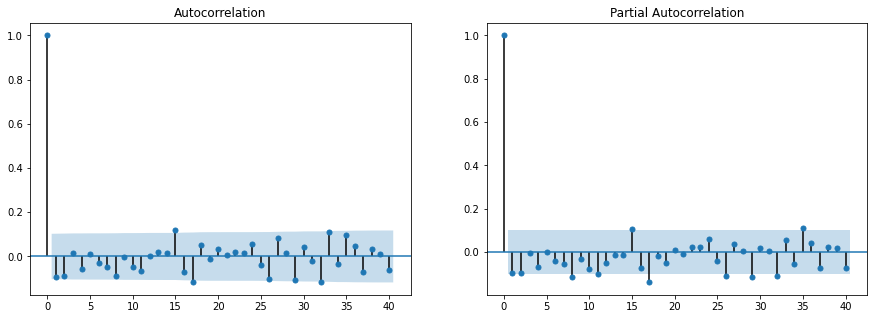

In [34]:
plot_acf_pacf(wn)

As expected the white noise series only has a significant auto-correlation and partial auto-correlation values at lag zero.

White noise is an example of a **stationary** time series. A stationary time series has constant mean, constant variance, and constant auto-correlation structure over time, but for stationary time series in general, the auto-correlations can be significant at lags $k > 0$.

**NOTE:** The `statsmodels` packages uses the engineering convention for displaying partial autocorrelation. The value at 0 lag, which always must be 1, is displayed. In many statistical packages, including R, this 0 lag value is not displayed. This difference in conventions can lead to a lot of confusion.

Let's see what happens when we add a trend and seasonality to a white noise series.

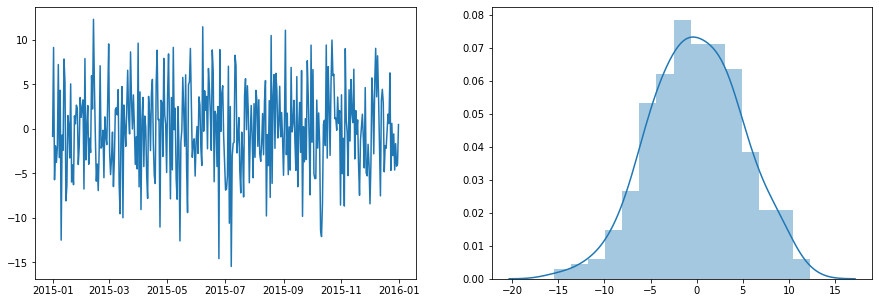

In [37]:
dates = pd.date_range(start = '1-1-2015', end = '12-31-2015', freq = 'D')
wn = pd.Series(nr.normal(scale = 5, size = len(dates)), index = dates)
plot_ts_resid(wn)

- Create a new series `wnt` composed of a trend $X_t = 0.5 \cdot t$ and the white noise from above. Then plot the series. HINT: To do this, first create an array called `trend` that is just an integer index of the timestamp `dates`. This array stores the values of $t$ in the above equation. You can then add the trend and white noise to get the new series.

In [52]:
t = np.array(range(len(dates)))
wnt = .5 * t + wn
# Looks like there's a trend in the WNT component (if I've done it right...)

- Plot the distribution of the new series. What can you conclude?

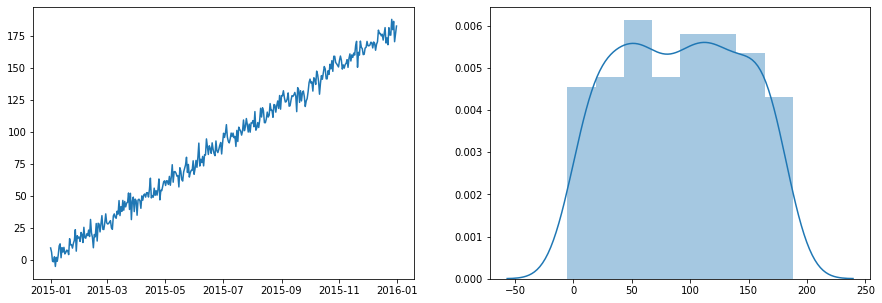

In [55]:
# Time periods are related to each other, in a decreasing manner...
plot_ts_resid(wnt)

- Plot the ACF and PACF using the `plot_acf_pacf` function. Use up to 50 lags. Based on what you see, what can you conclude about the trend of the data?

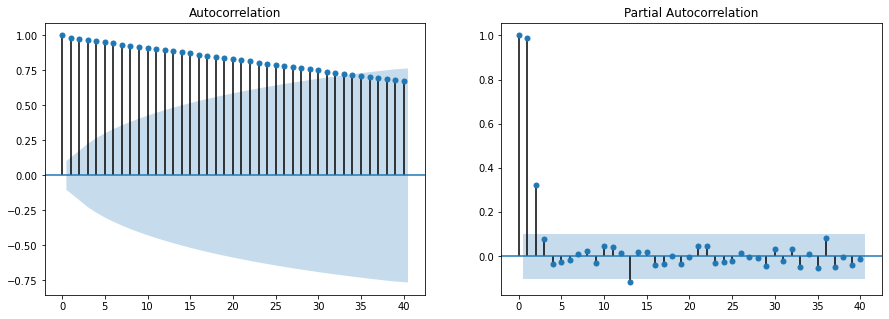

In [56]:
plot_acf_pacf(wnt, lags = 40)

- Is a time series with a trend stationary?

- Let's now add periodicity to the white noise using the **sinusoidal component** `2 * sin(pi*x/6)`. Name the new series `wnp` and plot it.

In [64]:
wnp = 25 * np.sin(np.pi * t/6) + wnt

- Plot the distribution of the new series. What can you conclude?

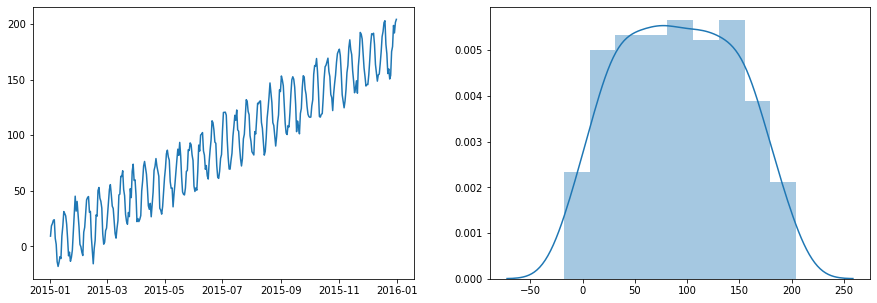

In [65]:
plot_ts_resid(wnp)

- To see what's happening next, it may help to zoom in on a narrower window of the above plot. Show the time series plot for the first 30 data points.

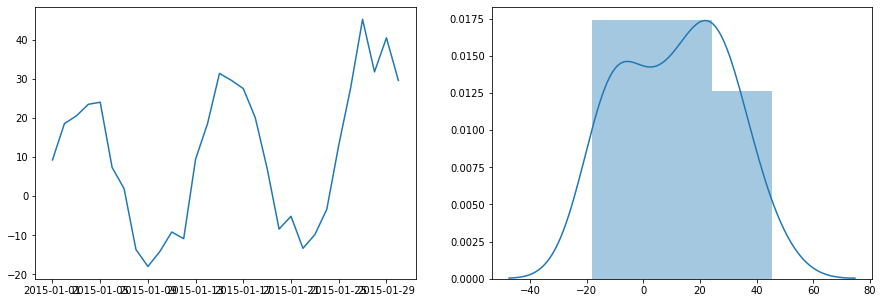

In [66]:
plot_ts_resid(wnp[:30])

- Plot the ACF and PACF of the time series plot up to 50 lags. Based on what you see, what can you conclude about the periodicity of the data?

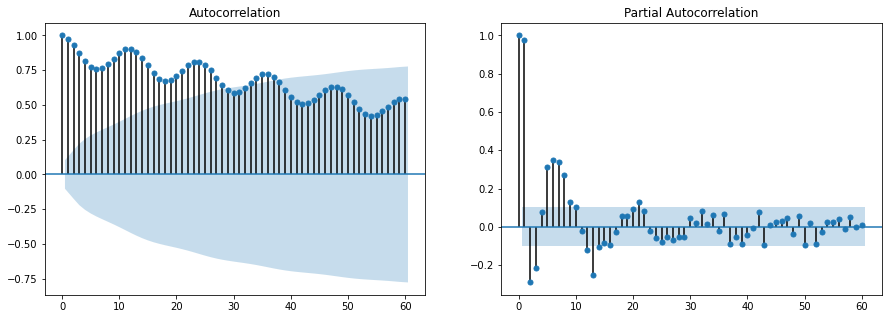

In [69]:
plot_acf_pacf(wnp, lags = 60)

- Does the periodic behavior of the ACF and PACF continue or die out?

- Create a new series by adding the trend component, the seasonal component and the white noise together. Call this series `wntp`. Plot the series.

In [ ]:
wntp = 25 * np.sin(np.pi)

- Plot the ACF and PACF of the series and compare it to the previous two.

- Of the ACF and the PACF, which do you find more helpful in teaching us something about the data?

### End of exercise

## Random Walks

A **random walk** is the defined by the sum of a white noise series. In other words, if $\{w_t\}$ is a white noise series and $y_t = y_{t-1} + w_t$, then $\{y_t\}$ is a random walk. If we rewrite the series as $w_t = y_t - y_{t-1}$, we notice that we can get white noise by taking the **difference** $y_t - y_{t-1}$ of a random walk at lag 1.

A random walk has constant mean, but its the variance increases with time and it is un-bounded. Therefore, a random walk is **non-stationary**. You can see the erratic nature of a random walk by rerunning the cell below multiple times. Notice how the random walk is created by creating a white noise process and using the cumulative sum function `cumsum` on it.

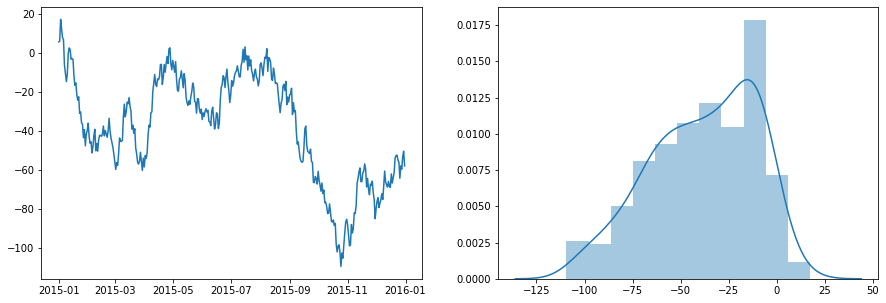

In [77]:
dates = pd.date_range(start = '1-1-2015', end = '12-31-2015', freq = 'D')
wn = pd.Series(nr.normal(scale = 5, size = len(dates)), index = dates)
rw = wn.cumsum()

plot_ts_resid(rw)

Let's re-create the random walk a few different times and see how each random walk differs from the rest.

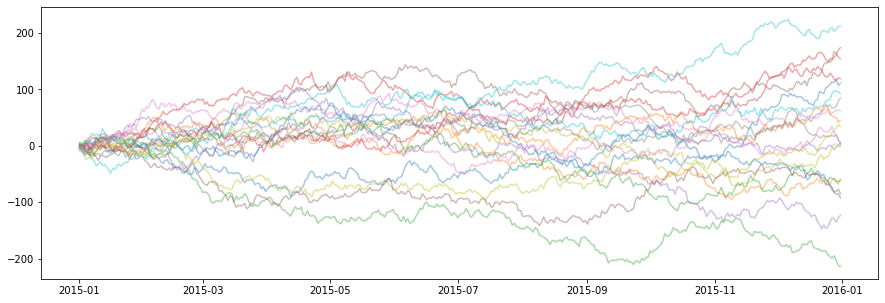

In [81]:
dates = pd.date_range(start = '1-1-2015', end = '12-31-2015', freq = 'D')

for _ in range(20):
    wn = pd.Series(nr.normal(scale = 5, size = len(dates)), index = dates)
    rw = wn.cumsum()
    sns.lineplot(rw.index, rw, alpha = 0.4);

A random walk is an example of a **Markov chain**, which is a stochastic process (a series of time-dependent random variables) where each value only depends on the previous one.

Let's also plot the ACF and PACF of the random walk for up to 40 lags.

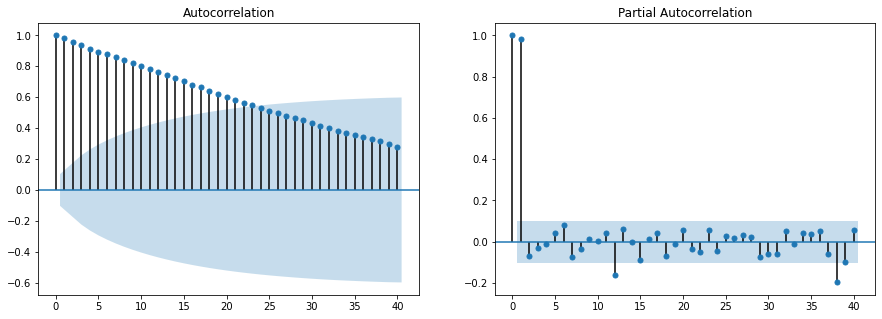

In [82]:
plot_acf_pacf(rw)

## STL decomposition of time series

We have looked at the properties of several types of time series. 

- White noise series
- Random walks
- White noise series with trend
- White noise series with seasonal component

A direct decomposition model is known as **STL** which stands for **seasonal and trend decomposition using loess**. Not too surprisingly this model does the following:

- The trend is removed using a LOESS regression model, which is a non-linear regression method that builds on the ideas developed in linear regression.
- The seasonal component is removed using a regression on periodic components.
- The remainder is known as the residual and should behave like white noise. In times series analysis, the residuals are sometimes called **innovations**. Can you guess why?

The decomposition can be either **additive** or **multiplicative**. The additive model simply sums the components and is written:

$$TS(t) = S(t) + T(t) + R(t)$$

The multiplicative model multiplies the three components. This model is particularly useful in the common case where the seasonal effect increases in proportional to the trend. We can write this model as an additive model by applying a log transformation:

$$TS(t) = S(t) \cdot T(t) \cdot R(t)$$

Let's try this out on a time series which has a seasonal, trend, and white noise residual component.

In [84]:
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    return(pd.DataFrame({'ts': ts, 'trend': res.trend, 'seasonal': res.seasonal, 'resid': res.resid}, 
                        index = ts.index))

decomp = decomp_ts(wnp)
decomp.head()

,ts,trend,seasonal,resid
2015-01-01,9.272269,NaN,0.278187,NaN
2015-01-02,18.553102,NaN,-0.744082,NaN
2015-01-03,20.525732,NaN,0.820638,NaN
2015-01-04,23.483736,15.022733,-0.386803,8.847806
2015-01-05,24.027081,11.749335,0.721417,11.556329


Note that there are missing values in the trend and residuals at the beginning but also at the end of the data. So to avoid running into problems, we will replace the missing values by back-filling the beginning and forward-filling the ending.

In [85]:
decomp = decomp.bfill().ffill()

Once we decompose the data, we can then look at the ACF and PACF of the residuals.

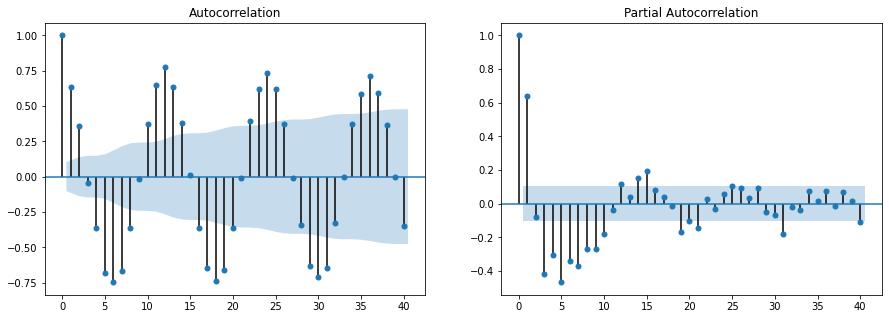

In [86]:
plot_acf_pacf(decomp['resid'], lags = 40)

Does it appear that the STL process has removed the trend and seasonal components of the time series fully or partially? With real data, it's hard to answer that, since some of the significant correlation values are significant by chance.

## ARIMA models for the residual series

Now that we have investigated the basic properties of time series and some decomposition methods, we can try to decompose any time series data and then focus our attention on modeling the residuals.

The class of models we will investigate are known and **autoregressive integrated moving average** or **ARIMA** model. We will work our way through each component of this model in the next few subsections. 

The ARIMA model and its relatives are **linear** in their coefficients. ARIMA models are in effect linear regression models. However, as you will see, ARIMA models are constructed to account for the serial correlations in time series data.

### Autoregressive model $\text{AR}(p)$

The values of an **autoregressive** or **AR** time series are determined by a linear combination of the past values. In other words, the AR model accounts for serial correlation in the values of the time series. We can write the value of an autoregressive series of **order** $p$ or $\text{AR}(p)$ series at time t as:

$$X_t = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} \dots \alpha_p X_{t-p} + w_t$$

where $w_t$ is a white noise process.

An AR process has the following properties:

- The value of $\rho_0$ is always equal to 1.
- The auto-correlations can be written as $p_k = \alpha^k$.
- The number of nonzero PACF values is equal to $p$.

AR models are specifically for **stationary time series** (hence the importance of decomposing the series first). If the variance is not constant or the trend component has not been removed, AR models will not produce satisfactory results.

### Moving average model $\text{MA}(q)$

For a **moving average** or **MA** model the value of the time series at time `t` is determined by a linear combination of past white noise terms. In other words, the MA model accounts for auto-correlation in the noise terms. We can write the $\text{MA}(q)$ model as the linear combination of the last $q$ white noise terms $w_i$:

$$x_t = w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$

An MA process has the following properties:

- The value of $\rho_0$ is always 1.
- The number of nonzero $\rho_{k \ne 0}$ values is equal to $q$.

MA models are specifically for **stationary time series**. If the variance is not constant or the trend component has not been removed, MA models will not produce satisfactory results.

NOTE: It can be shown theoretically that an $\text{AR}(1)$ process is equivalent to an $\text{MA}(\infty)$ process under the assumption that $-1 < \alpha_1 < 1$. In fact, any stationary process can be represented as $\text{MA}(\infty)$. Similarly, an $\text{MA}(1)$ process is equivalent to an $\text{AR}(\infty)$ process.

### The Autoregressive moving average model $\text{ARMA}(p, q)$

We can combine the AR and MA models to create an **autoregressive moving average** or **ARMA** model. This model accounts for serial correlation in both noise terms and values. We would expect we can write an ARMA model of order $(p, q)$ as:

$$x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} \dots \alpha_p x_{t-p} +\\
w_t + \beta_1 w_{t-1} + \beta_2 w_{t-2} + \cdots + \beta_q w_{t-q}$$



The function in the code in the cell below does the following:
1. Defines an ARMA process of the specified orders.
2. Tests the stationarity and invertibility (stability) of the process.
3. Returns Pandas series with samples generated from the ARMA process. Note that the `generate_sample` function adds white noise with standard deviation of 1.0 unless otherwise specified. 

Let's simulate and plot an $\text{AR}(2)$: $X_t = 0.75 X_{t-1} + 0.25 X_{t-2}$ process. We use a helper function to also produce a summary.

In [88]:
nr.seed(4477)
def ARMA_process(ar_coef, ma_coef, start = '1-2005', end = '1-2015'):
    dates = pd.date_range(start = start, end = end, freq = 'M')
    ts = arima_process.ArmaProcess(ar_coef, ma_coef)
    print('Is the time series stationary? ' + str(ts.isstationary))
    print('Is the time series invertible? ' + str(ts.isinvertible))
    return(pd.Series(ts.generate_sample(120), index = dates))


ts_series_ar2 = ARMA_process(ar_coef = [1, .75, .25], ma_coef = [1])

Is the time series stationary? True
Is the time series invertible? True


Notice that we have applied some tests to determine if our choice of $AR(2)$ coefficients are stable. 

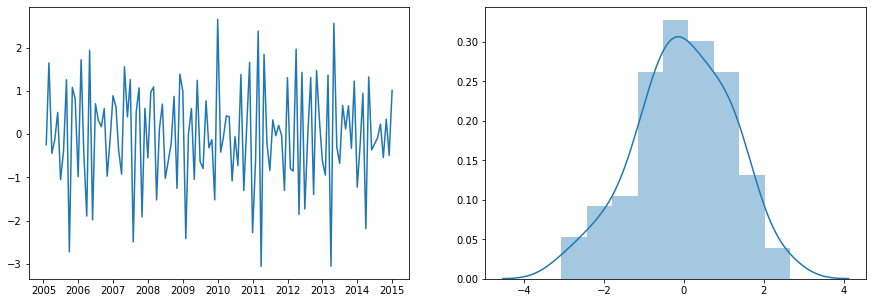

In [89]:
plot_ts_resid(ts_series_ar2)

The values of this time series look fairly random. The series shows significant deviations from the zero, but has no trend. 

The question now is, what are the statistical properties of this $\text{AR}(2)$ process? Let's look at some plots.

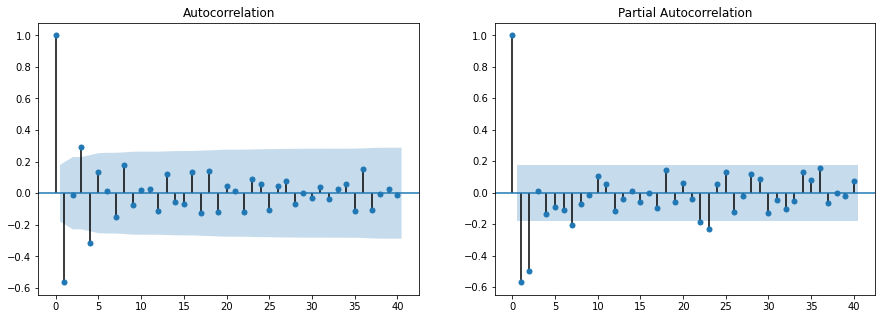

In [90]:
plot_acf_pacf(ts_series_ar2, lags = 40)

The $\text{AR}(2)$ process produces a series with significant correlations in the lags, as shown in the  ACF plot. More importantly, the PACF has 2 significant non-zero lag values, consistent with an $\text{AR}(2)$ model. 

The AR time series model estimates the coefficients for the order of the model specified. The code in the cell below does the following:
1. Uses the `ARIMA` function from the `statsmodels` package to define model. The order of  the AR model is specified as `(p, 0, 0)`.
2. Fits the coefficient values using the `fit` method on the model object.
3. Prints the output of the `summary` method, showing useful statistics to understand the model.  

Run this code and examine  the  properties of the  results. 

In [91]:
def model_ARIMA(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    try: 
        model = ARIMA(ts, order = order)
        model_fit = model.fit(disp = 0, method = 'mle', trend = 'nc', start_ar_lags = 7)
        print(model_fit.summary2())
        return model_fit
    except ValueError:
        print('This model does not properly compute!')

        
ar2_model = model_ARIMA(ts_series_ar2, order = (2, 0, 0))

                           Results: ARMA
Model:              ARMA             BIC:                 319.9354  
Dependent Variable: y                Log-Likelihood:      -152.79   
Date:               2020-08-20 20:14 Scale:               1.0000    
No. Observations:   120              Method:              mle       
Df Model:           2                Sample:              01-31-2005
Df Residuals:       118                                   12-31-2014
Converged:          1.0000           S.D. of innovations: 0.861     
No. Iterations:     6.0000           HQIC:                314.969   
AIC:                311.5730                                        
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
ar.L1.y     -0.8407     0.0795   -10.5735   0.0000   -0.9966   -0.6849
ar.L2.y     -0.4881     0.0795    -6.1358   0.0000   -

Note the following about the AR model:

- The estimated AR coefficients have values fairly close to the values used to generate the data. Further, true values are within the standard errors and confidence intervals of the estimated coefficients. Notice negative sign of the coefficient values. 
- The p-values are small and standard error ranges do not include 0 so the coefficient values are significant.


Now let's look at a moving average $\text{MA}(q)$ model. The code in the cell below computes an $\text{MA}(1)$ model with a coefficient $\beta_1 = 0.75$.

Is the time series stationary? True
Is the time series invertible? True


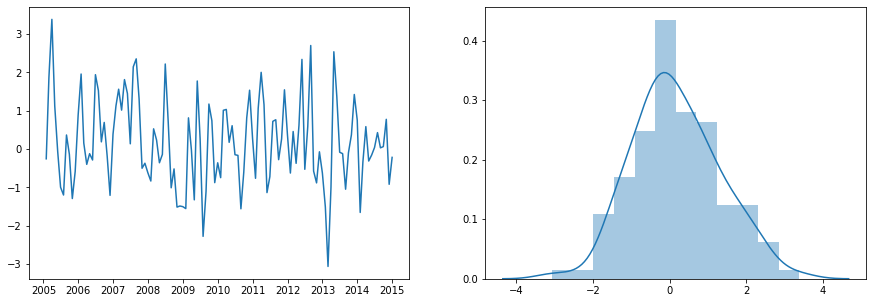

In [92]:
ts_series_ma1 = ARMA_process(ar_coef = [1], ma_coef = [1, .75])
plot_ts_resid(ts_series_ma1)

The time series of the $\text{MA}(1)$ process looks fairly random, with no trend. 

Next, let's plot the ACF and PACF of the $\text{MA}(1)$ process. 

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


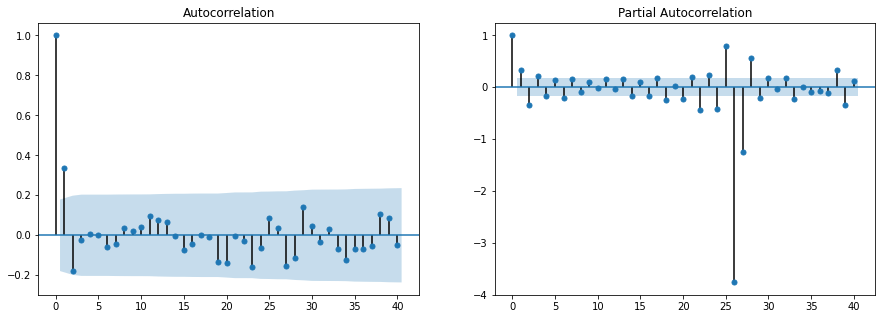

In [93]:
plot_acf_pacf(ts_series_ma1, lags = 40)

The ACF exhibits only one non-zero lag, which is expected for an $\text{MA}(1)$ process. There are also some significant non-zero lags in the PACF, which is a result of random noise.  

Let's try to estimate the coefficients of the MA time series. The code in the cell below fits and $\text{MA}(1)$ model to the time series. The model is specified as `(0, 0, q)`.

In [94]:
ma1_model = model_ARIMA(ts_series_ma1, order = (0, 0, 1))

                           Results: ARMA
Model:              ARMA             BIC:                 329.7539  
Dependent Variable: y                Log-Likelihood:      -160.09   
Date:               2020-08-20 20:21 Scale:               1.0000    
No. Observations:   120              Method:              mle       
Df Model:           1                Sample:              01-31-2005
Df Residuals:       119                                   12-31-2014
Converged:          1.0000           S.D. of innovations: 0.908     
No. Iterations:     8.0000           HQIC:                326.443   
AIC:                324.1789                                        
-----------------------------------------------------------------------
            Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
-----------------------------------------------------------------------
ma.L1.y     0.9690      0.0258    37.4926    0.0000    0.9183    1.0196
--------------------------------------------------

Note the following about the AR model:

- The estimated MA coefficient has a value fairly close to the value used to generate the data. Further, true value is within the standard error and confidence intervals of the estimated coefficient. 
- The p-values are small and standard error ranges do not include 0 so the coefficient values are significant.


The code in the cell below simulates and plots an $\text{ARMA}(1, 1)$ model.

Is the time series stationary? True
Is the time series invertible? True


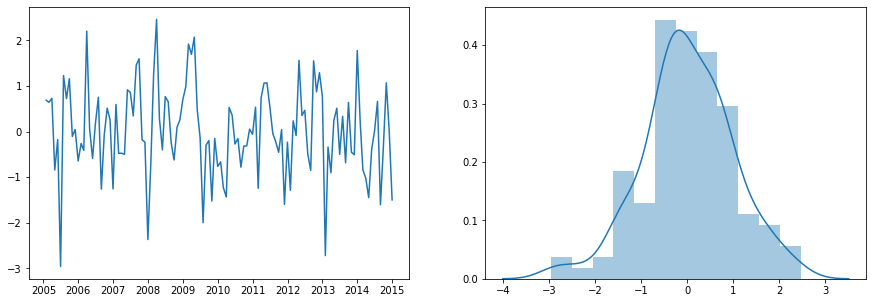

In [101]:
ts_series_arma11 = ARMA_process(ar_coef = [1, .6], ma_coef = [1, .75])
plot_ts_resid(ts_series_arma11)

As expected, the $\text{ARMA}(1, 1)$ series has properties of both an $\text{AR}(1)$ and $\text{MA}(1)$ series. 

And let's plot its ACF and PACF:

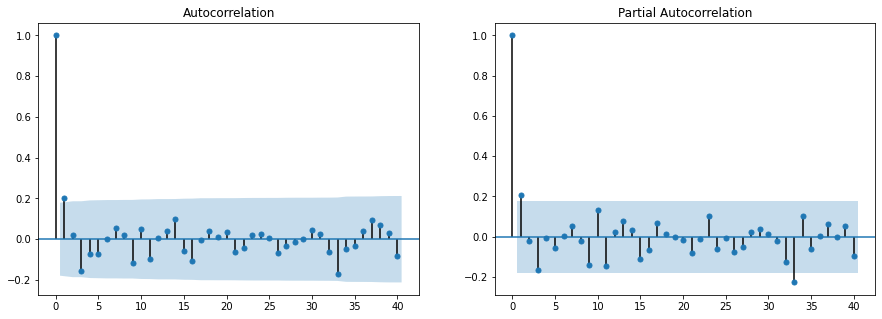

In [102]:
plot_acf_pacf(ts_series_arma11, lags = 40)

And once again let's estimate the model, specified by `(p, 0, q)`.

In [103]:
arma11_model = model_ARIMA(ts_series_arma11, (1, 0, 1))

                           Results: ARMA
Model:              ARMA             BIC:                 344.5323  
Dependent Variable: y                Log-Likelihood:      -165.08   
Date:               2020-08-20 20:24 Scale:               1.0000    
No. Observations:   120              Method:              mle       
Df Model:           2                Sample:              01-31-2005
Df Residuals:       118                                   12-31-2014
Converged:          1.0000           S.D. of innovations: 0.958     
No. Iterations:     6.0000           HQIC:                339.566   
AIC:                336.1699                                        
-----------------------------------------------------------------------
            Coef.     Std.Err.      t       P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
ar.L1.y     0.1683      0.2799    0.6013    0.5476    -0.3803    0.7169
ma.L1.y     0.0398      0.2743    0.1451    0.8846

### Autoregressive Integrated Moving Average Model

The **autoregressive integrated moving average (ARIMA)** model adds an integrating term to the ARMA model. The integrating component performs differencing to model a random walk component. The integrating component models one of the **non-stationary** parts of a time series. The ARIMA model is defined by orders $(p, d, q)$. We have already looked at $\text{AR}(p)$ and $\text{MA}(q)$ models. The order of the differencing operator of the integrating term is defined by $d$. Since the integrating term is a differencing operator, there is no coefficient to estimate. 

In a previous section we have already simulated a random walk series, and investigated its properties. Here's the random walk again.

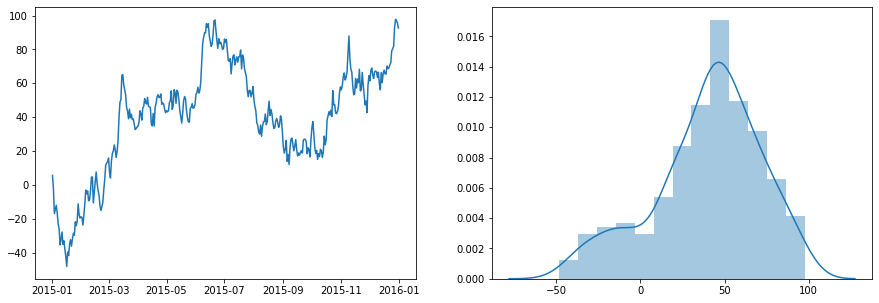

In [104]:
plot_ts_resid(rw)

The code in the cell below uses its `diff` method to perform first order differencing on the time series. This operation is an $\text{ARIMA}(0, 1, 0)$ model.

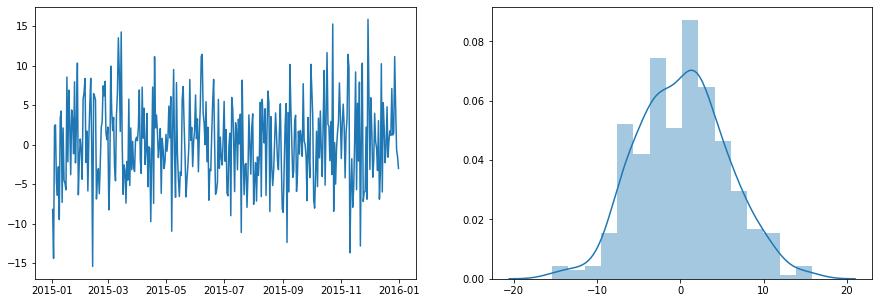

In [105]:
rw_diff = rw.diff()
# diff is the same as rw - rw.shift(1)
plot_ts_resid(rw_diff)

The random walk has been transformed. The time series does not wander any more. We can further extend the ARIMA model by letting it model seasonality-related components. The result is called a Seasonal ARIMA or **SARIMA** model, written as $\text{SARIMA}(p, d, q)(P, D, Q)_m$. The parameters $(p, d, q)$ are from ARIMA, and the parameters $(P, D, Q)$ their equivalent counterparts, but apply to the seasonal component. Finally, $m$ is the length of the peroid that makes the data seasonal.

### Exercise

What are the statistical properties of the random walk after the $\text{ARIMA}(0, 1, 0)$ has been applied? Plot the distribution properties, the ACF and PACF of the remainder. **HINT:** You will need to remove the first value from the difference series since the difference operator cannot work on the first element of a time series. 

In [ ]:
# plot the distribution

In [ ]:
# plot the ACF and PACF

What are your conclusions?

### End of exercise

## An example with real data

So far we have been studying time series that we generated using a pre-defined stochastic process, but now let's apply the models we have been working with on some real-world data. We will work with a data set which shows the consumption of chocolate, beer and electricity in Australia from 1958 to 1991.

In [106]:
CBE = pd.read_csv('https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/cbe.csv')
CBE.index = pd.date_range(start = '1-1-1958', end = '12-31-1990', freq = 'M')

CBE.head()

,choc,beer,elec
1958-01-31,1451,96.3,1497
1958-02-28,2037,84.4,1463
1958-03-31,2477,91.2,1648
1958-04-30,2785,81.9,1595
1958-05-31,2994,80.5,1777


We limit our example to looking at beer consumption.

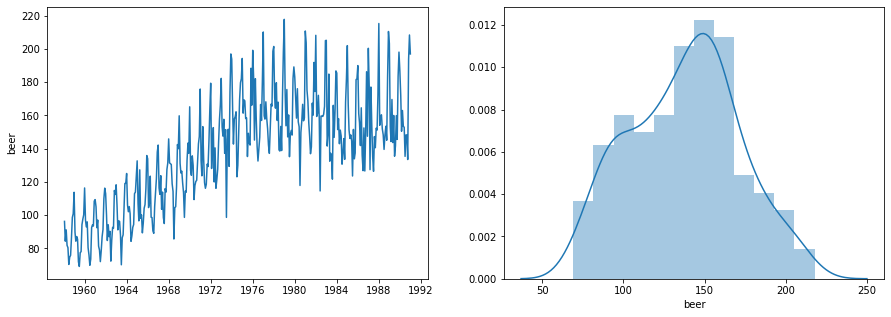

In [107]:
plot_ts_resid(CBE['beer'])

Notice that for each of these time series the amplitude of the seasonal variation grows with time. This is a common situation with real world data. Seeing this situation indicates that we should use a **multiplicative decomposition model**.  

The multiplicative model can be easily transformed to an additive model by taking the logarithm of the values.

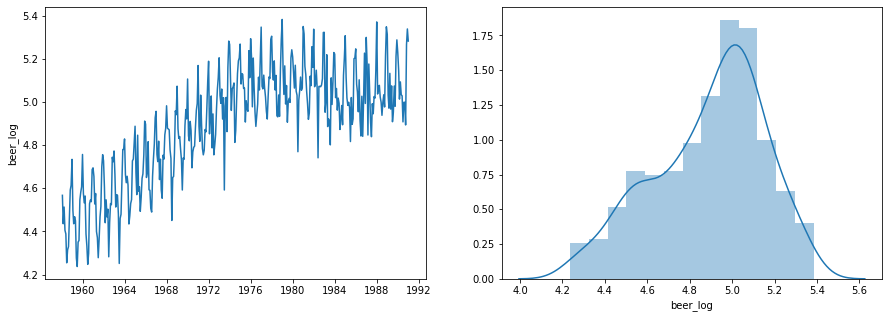

In [108]:
CBE['beer_log'] = np.log(CBE['beer'])
plot_ts_resid(CBE['beer_log'])

Notice the following properties about this time series.
- It has a significant trend.
- The time series have a noticeable seasonal component.
- The magnitude of the seasonal component increases with trend in the un-transformed time series. 
- The seasonal component of the log transformed series has a nearly constant magnitude, but decreases a bit with time. 

These results indicate that an STL decomposition is required. Further, a multiplicative (log transformed) STL model is preferred.


Now that we have explored the data, the next step is to compute and evaluate a model. Note that we cannot evaluate time series models using a random split, because the validation data needs to contain future timestamps. In this case, we will hold back the last 12 months of data before we train the model. The final 12 months of data can then be used to evaluate the model.


### Fitting linear regression

Before training any time series model, let's see how our old friend linear regression does. In cases where the data is relatively well behaved, we can train a model using linear regression, but we need to do some pre-processing to account for the time series nature of the data. This can be a manual and laborious process, but let's go through it for the sake of illustration.

In [109]:
CBE['month_int'] = CBE.reset_index().index # returns the row number
CBE['month_sqr'] = CBE['month_int']**2

from scipy.stats import zscore
CBE[['month_int', 'month_sqr']] = CBE[['month_int', 'month_sqr']].apply(zscore)

years = int(len(CBE)/12)
CBE['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * years
dummies = pd.get_dummies(CBE['month'])
CBE[list(dummies.columns)] = dummies
CBE['beer_log_lag_1'] = CBE['beer_log'].shift(1).bfill()
CBE.head(5)

,choc,beer,elec,beer_log,month_int,month_sqr,month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,beer_log_lag_1
1958-01-31,1451,96.3,1497,4.567468,-1.727682,-1.116450,Jan,0,0,0,0,1,0,0,0,0,0,0,0,4.567468
1958-02-28,2037,84.4,1463,4.435567,-1.718935,-1.116428,Feb,0,0,0,1,0,0,0,0,0,0,0,0,4.567468
1958-03-31,2477,91.2,1648,4.513055,-1.710187,-1.116364,Mar,0,0,0,0,0,0,0,1,0,0,0,0,4.435567
1958-04-30,2785,81.9,1595,4.405499,-1.701439,-1.116257,Apr,1,0,0,0,0,0,0,0,0,0,0,0,4.513055
1958-05-31,2994,80.5,1777,4.388257,-1.692691,-1.116107,May,0,0,0,0,0,0,0,0,1,0,0,0,4.405499


Examine the new features in the data frame. You can see the features for modeling the trend and the dummy variables for the seasonal variation.

Next we compute a linear model for coefficients of the trend and seasonal features.

In [110]:
import sklearn.linear_model as lm

validation_cut_off = '1989-12-31'
cols = ['beer_log_lag_1', 'month_int', 'month_sqr', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
X_train, Y_train = CBE.loc[:validation_cut_off, cols], CBE.loc[:validation_cut_off, 'beer_log']
X_valid, Y_valid = CBE.loc[validation_cut_off:, cols], CBE.loc[validation_cut_off:, 'beer_log']

lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X_train, Y_train)

Once the model is trained, we can use it to make predictions. We can predict for the whole data, which includes the part of the data we held-out. The prediction for the hold-out sample is called a **forecast**.

In [111]:
CBE['beer_log_pred'] = mod_fit.predict(CBE[cols])

Let's have a look at how these predicted trend and seasonal components fit to the data. The forecast is shown on the far right-side of the plot.

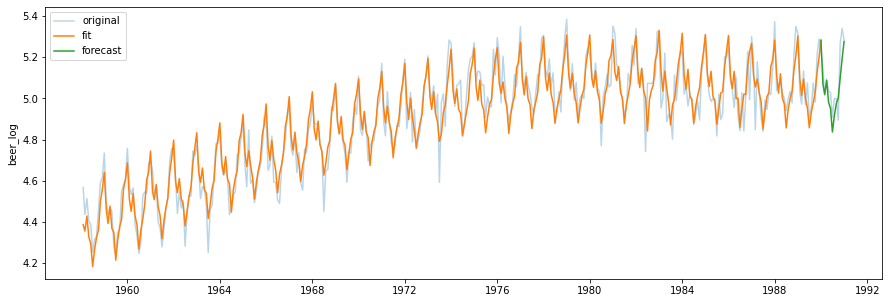

In [112]:
sns.lineplot(CBE.index, CBE['beer_log'], alpha = 0.3)
sns.lineplot(X_train.index, mod_fit.predict(X_train))
sns.lineplot(X_valid.index, mod_fit.predict(X_valid))
plt.legend(['original', 'fit', 'forecast']);

You can see that the trend and seasonal components fit the actual data fairly well. 

To have a point of comparison, execute the code in the cell below to compute the **root mean square error (RMSE)** of the fit of the model for the last 12 months of the time series.

In [114]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_valid, mod_fit.predict(X_valid))
print('RMSE = {:.2f}'.format(mse**0.5))

RMSE = 0.08


Next, let's have a look at a time series plot and distribution plots of the residuals. Execute the code in the cell below and examine the results. 

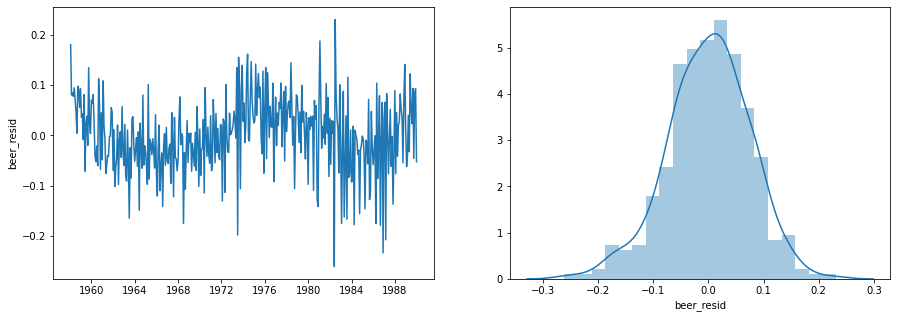

In [115]:
CBE['beer_resid'] = CBE['beer_log'] - CBE['beer_log_pred']

plot_ts_resid(CBE.loc[:validation_cut_off, 'beer_resid'])

The time series plot of the residual shows some minor periodic behavior. The distribution plots show the values to be close to normally distributed. 

One other question we can ask is if the residual series is stationary. The code in the cell below applies the Dicky Fuller test.

In [116]:
def DF_Test(ts):
    ts = ts[ts.notna()]
    stationary = adfuller(ts)
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    return None


DF_Test(CBE.loc[:validation_cut_off, 'beer_resid'])

D-F statistic = -1.7137828382450897
p-value = 0.4240255001969623
number of lags used = 17
Critical value at 5% confidence = -2.869469418606909
Critical value at 10% confidence = -2.570994248260623


Notice that the results are marginal. We cannot reject the null hypothesis (the time series is not stationary) at the 95% confidence level, but can at the 90% confidence level. This should not be too surprising, given the periodic behavior seen in the time series plot.

### Fitting a time series model

Let’s extend the analysis now to use the models we learned about in this chapter. We can begin by decomposing the data. In this case, we will use a **multiplicative model** since the magnitude of the seasonal component generally increases with increasing trend.

In [117]:
CBE_decomp = decomp_ts(CBE['beer_log'])
CBE_decomp.head(10)

,ts,trend,seasonal,resid
1958-01-31,4.567468,NaN,0.039683,NaN
1958-02-28,4.435567,NaN,-0.025683,NaN
1958-03-31,4.513055,NaN,0.054447,NaN
1958-04-30,4.405499,NaN,-0.048373,NaN
1958-05-31,4.388257,NaN,-0.085620,NaN
1958-06-30,4.254193,NaN,-0.202271,NaN
1958-07-31,4.314818,4.464318,-0.120821,-0.028680
1958-08-31,4.329417,4.461407,-0.063312,-0.068678
1958-09-30,4.457830,4.459538,-0.025953,0.024245
1958-10-31,4.592085,4.459510,0.096456,0.036118


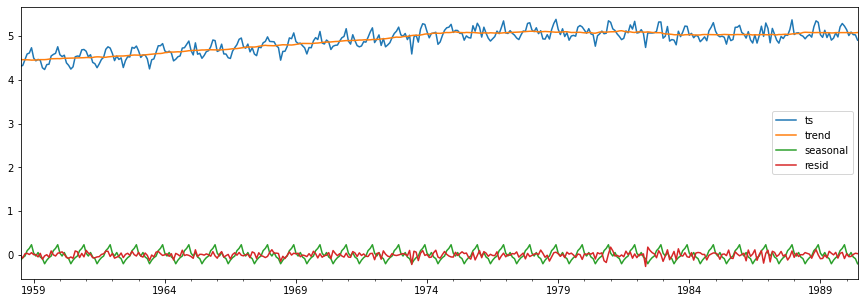

In [118]:
CBE_decomp = CBE_decomp.iloc[6:-6] # drop the rows with missing values
CBE_decomp.plot();

Note the following about these results:

- The periodic component looks reasonable, but may not be stationary as evidenced by the remainder.
- The removal of the trend component appears to be satisfactory.

We can apply the **Dicky Fuller test** to determine if the residual is stationary. The null hypothesis is that the time series is not stationary, but with no trend. 

In [119]:
DF_Test(CBE_decomp['resid'])

D-F statistic = -10.328136510285411
p-value = 2.889444928081529e-18
number of lags used = 16
Critical value at 5% confidence = -2.869447722240253
Critical value at 10% confidence = -2.570982681065269


Given the DF statistic and p-value we can reject the null hypothesis that the residual is not stationary. 

As a next step, compute and plot the ACF and PACF for the remainder series.

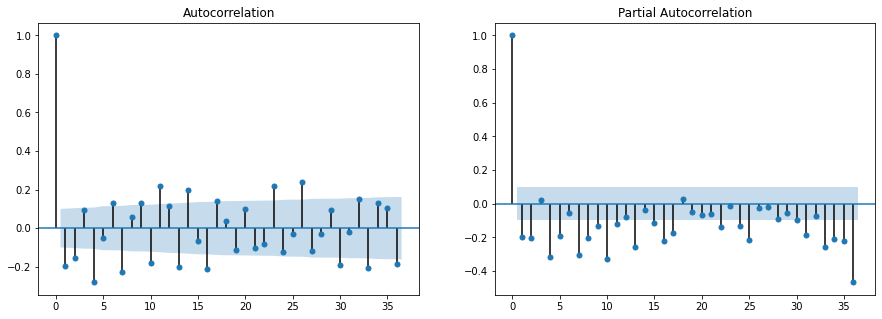

In [120]:
plot_acf_pacf(CBE_decomp['resid'], lags = 36)

The ACF and PACF exhibit both AR and MA behavior. However, there are signs of periodicity which the STL decomposition has not removed. 

Now that we have an STL decomposition of the time series, we can compute an ARIMA model for the residual.

In [121]:
arima_model = model_ARIMA(CBE_decomp['resid'], order = (2, 1, 2))

                           Results: ARIMA
Model:              ARIMA            BIC:                 -1035.4389
Dependent Variable: D.resid          Log-Likelihood:      532.59    
Date:               2020-08-20 20:49 Scale:               1.0000    
No. Observations:   383              Method:              mle       
Df Model:           4                Sample:              08-31-1958
Df Residuals:       379                                   06-30-1990
Converged:          1.0000           S.D. of innovations: 0.060     
No. Iterations:     29.0000          HQIC:                -1047.348 
AIC:                -1055.1791                                      
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ar.L1.D.resid    -0.6993    0.1286  -5.4383  0.0000  -0.9513  -0.4473
ar.L2.D.resid    -0.2906    0.0495  -5.8731  0.0000  -0.3

The model looks good, but how do we know the right values for $(p, d, q)$? It's always better to start small. The standard error of the coefficients being high usually indicates that the model is overfit or over-parameterized. We need a criteria to compare models with different values of $(p, d, q)$. The **Akaike information criteria (AIC)** and **Bayesian information criteria (BIC)** are two closely related measures for assessing a model's fit:

$$
\begin{align}
\text{AIC} &= 2k - 2 \ln(\hat L) \\
\text{BIC} &= \ln(n)k - 2 \ln(\hat L)
\end{align}
$$

where $\hat L$ is the likelihood of the data given the fitted model parmaters, $k$ is the number of model parameters, and $n$ is the number of observations. Lower values for AIC and BIC means we have a better fit. If AIC and BIC lead to different candidates for the best model, we can use other techniques to validate the best model.

We can use the `auto_arima` function to iterates over a grid of $(p, d, q)$ and the seasonal $(P, D, Q)$ parameters. For each combination the BIC is computed and compared to the best previous model. For each combination the BIC is computed and compared to the best previous model.

In [ ]:
# !conda install -c saravji pmdarima -y
# !pip install pyramid-arima

In [122]:
from pmdarima import auto_arima
best_fit = auto_arima(CBE.loc[:validation_cut_off, 'beer_log'], 
                      max_p = 3, max_d = 1, max_q = 3, 
                      m = 12, max_P = 1, max_D = 1, max_Q = 1, 
                      information_criterion = 'bic', 
                      trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=-425.265, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=-623.432, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=-597.582, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=-431.152, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=-443.850, Time=0.03 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=-548.074, Time=0.30 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : BIC=-543.236, Time=0.18 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : BIC=-691.971, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : BIC=-444.279, Time=0.06 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : BIC=-819.255, Time=1.20 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : BIC=-560.629, Time=0.37 sec
 ARIMA(3,1,0)(1,0,1)[12] intercept   : BIC=-817.155, Time=1.11 sec
 ARIMA(2,1,1)(1,0,1)[12] inte

In [123]:
print(best_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  384
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 461.566
Date:                            Thu, 20 Aug 2020   AIC                           -911.132
Time:                                    20:54:47   BIC                           -887.444
Sample:                                         0   HQIC                          -901.735
                                            - 384                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2286      0.050     -4.601      0.000      -0.326      -0.131
ar.L2         -0.1824      0.054   

Examine the results above. You can see how the iteration over the model order eventually converged to a model with the smallest BIC.

Let's now visualize the forecast. With time series models we use the `predict_in_sample` to make predictions for the range of data that we used during training, and we use `predict` to make forecasts.

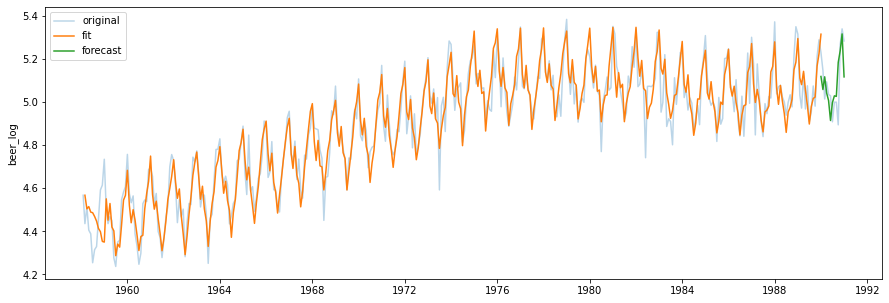

In [124]:
start_idx = 1
train_idx = X_train.reset_index().index[start_idx:]
n_periods = len(X_valid)

sns.lineplot(CBE.index, CBE['beer_log'], alpha = 0.3)
sns.lineplot(X_train.index[train_idx], best_fit.predict_in_sample(start = start_idx, end = train_idx.max()))
sns.lineplot(X_valid.index, best_fit.predict(n_periods = n_periods))
plt.legend(['original', 'fit', 'forecast']);

Notice how the predictions are initially a bit off, but overall the forecasts look reasonable.

RMSE = 0.11


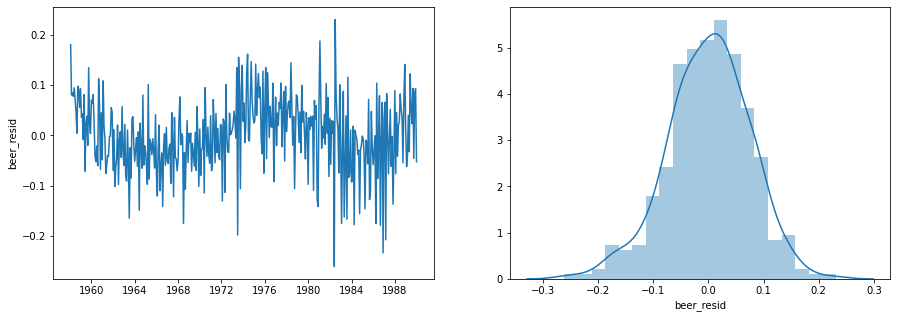

In [125]:
mse = mean_squared_error(Y_valid, best_fit.predict(n_periods = n_periods))
print('RMSE = {:.2f}'.format(mse**0.5))

CBE['beer_resid'] = CBE['beer_log'] - CBE['beer_log_pred']
plot_ts_resid(CBE.loc[:validation_cut_off, 'beer_resid'])

We can see that the ARIMA model has worse predictions than the regression model, so it may be in need of more tuning. Notice however that unlike the regression model, the pre-processing was minimal for the ARIMA model. So this is an advantage.

### Summary

In this notebook we explored basic properties of time series. We learned how ARMA models can be used with **stationary** data, and how we can decompose the data into a trend, a seasonal and a residual component and fit an ARMA model to its **residual component**. Alternatively, we learned how ARMA models can be extened to ARIMA by adding the **difference** operator, and SARIMA by adding a seasonal component. ARIMA can be used for non-stationary data with a trend, and SARIMA can be used with non-stationary data with a trend and seasonality. There are further extensions of these models that make it possible to model time series data when the variance changes over time, namely the **autoregressive conditional heteroskedasticity** or **ARCH** and **generalized autoregressive conditional heteroskedasticity** or **GARCH** model, but these models are beyond the scope of this notebook.